Using device: cuda
Epoch [1000/5000], NLL: 20057320.0000
Epoch [2000/5000], NLL: 18257408.0000
Epoch [3000/5000], NLL: 18246748.0000
Epoch [4000/5000], NLL: 18246748.0000
Epoch [5000/5000], NLL: 18246748.0000
Training completed in 103.20 seconds
Learned parameters:
β = [1.981557011604309, 0.40687423944473267, -0.4970940947532654, 0.7743846774101257, -0.3472518026828766, 0.9002389311790466]
σ = 1.5004
True parameters:
β = [1.9831584692001343, 0.4065134823322296, -0.4973895847797394, 0.7744303345680237, -0.3471899926662445, 0.9005032181739807]
σ = 1.5000
Skipping plot since p > 1 (plotting only works for a single predictor).


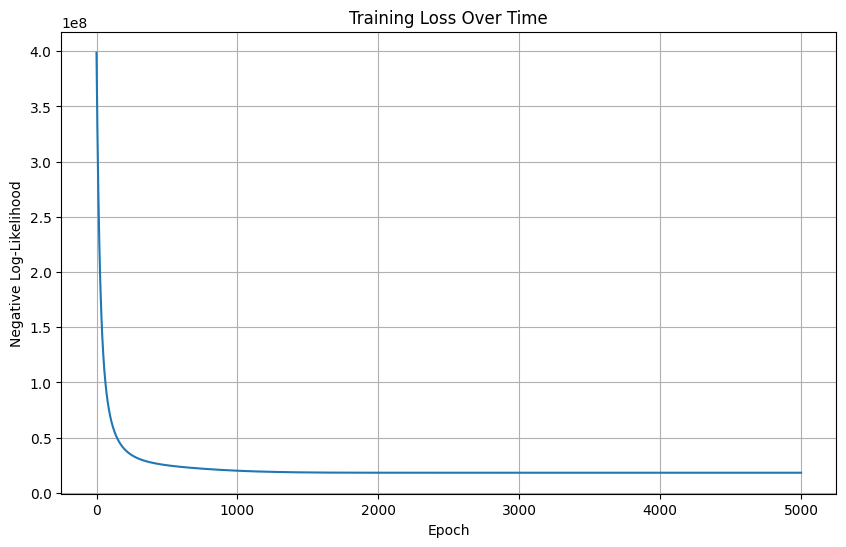

In [2]:
# Updated notebook with CUDA support

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(42)

# Determine device: use CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Generate synthetic data based on a linear model
# y_i ~ N(X_i β, σ²)
n = 10000000  # sample size
p = 5      # number of predictors (excluding intercept); change as needed

if p == 1:
    # For a single predictor, use linspace for clarity
    X = torch.linspace(0, 10, n).reshape(-1, p)  # Design matrix (without intercept)
else:
    # For multiple predictors, generate random features in [0, 10)
    X = torch.rand(n, p) * 10

# True parameters: Choose random intercept and slopes (shape: (p+1, 1))
true_beta = torch.randn(p+1, 1)
true_sigma = 1.5  # standard deviation of the error term

# Generate response variable with noise (μ = Xβ, σ = true_sigma)
X_with_intercept = torch.cat([torch.ones(n, 1), X], dim=1)  # Add intercept column
mu = X_with_intercept @ true_beta  # μ = Xβ
epsilon = torch.randn(n, 1) * true_sigma  # ε ~ N(0, σ²)
y = mu + epsilon  # y = Xβ + ε

# Move data (and true parameters if needed for plotting) to the selected device
X = X.to(device)
y = y.to(device)
true_beta = true_beta.to(device)

# Step 2: Define the linear model as y ~ N(Xβ, σ²)
# The model deduces the input dimension from an example design matrix.
class LinearModel(nn.Module):
    def __init__(self, example_x):
        super(LinearModel, self).__init__()
        input_dim = example_x.shape[-1]  # Deduce the number of predictors
        self.beta = nn.Parameter(torch.randn(input_dim + 1, 1))  # β vector includes intercept
        self.log_sigma = nn.Parameter(torch.tensor(0.0))  # log(σ) for numerical stability
        
    def forward(self, x):
        x_with_intercept = torch.cat([torch.ones(x.size(0), 1, device=x.device), x], dim=1)
        mu = x_with_intercept @ self.beta  # μ = Xβ
        return mu
    
    def sigma(self):
        return torch.exp(self.log_sigma)  # Convert log(σ) to σ
    
    def negative_log_likelihood(self, x, y):
        mu = self(x)
        sigma = self.sigma()
        # Negative log-likelihood for normal distribution
        return (torch.log(sigma) + 0.5 * ((y - mu) / sigma)**2).sum() + 0.5 * np.log(2 * np.pi) * y.numel()

# Step 3: Instantiate model and optimizer using X to deduce input dimension
model = LinearModel(X)
model = model.to(device)  # Move model to the selected device
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the model with timing
num_epochs = 5000
losses = []
start_time = time.time()  # Start the timer

for epoch in range(num_epochs):
    # Compute negative log-likelihood
    loss = model.negative_log_likelihood(X, y)
    losses.append(loss.item())
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop the timer
print(f"Training completed in {elapsed_time:.2f} seconds")

# Step 5: Extract learned parameters
learned_beta = model.beta.data.flatten()
learned_sigma = model.sigma().item()

print(f'Learned parameters:')
print(f'β = {learned_beta.tolist()}')
print(f'σ = {learned_sigma:.4f}')
print(f'True parameters:')
print(f'β = {true_beta.flatten().tolist()}')
print(f'σ = {true_sigma:.4f}')

# Step 6: Plot results (only if p==1)
# Note: Plotting is done on the CPU so ensure data is moved to CPU when plotting
if p == 1:
    plt.figure(figsize=(10, 6))
    
    # Convert tensors back to CPU for plotting
    X_cpu = X.cpu()
    y_cpu = y.cpu()
    true_beta_cpu = true_beta.cpu()
    
    # Plot training data
    plt.scatter(X_cpu.numpy(), y_cpu.numpy(), label='Observations', s=1)
    
    # Plot the true regression line
    x_range = np.linspace(0, 10, 100).reshape(-1, 1)
    x_range_with_intercept = np.column_stack([np.ones(100), x_range])
    plt.plot(x_range, x_range_with_intercept @ true_beta_cpu.numpy(), 'r', 
             label=f'True: y = {true_beta_cpu[0].item():.2f} + {true_beta_cpu[1].item():.2f}x')
    
    # Plot the fitted regression line
    with torch.no_grad():
        # Move x_range to device before model prediction, then back to cpu for plotting
        x_range_tensor = torch.FloatTensor(x_range).to(device)
        y_pred = model(x_range_tensor).cpu()
    plt.plot(x_range, y_pred.numpy(), 'g--', 
             label=f'Fitted: y = {learned_beta[0].item():.2f} + {learned_beta[1].item():.2f}x')
    
    # Plot confidence bands (μ ± 2σ)
    # For confidence bands, compute predictions using learned_beta on CPU
    learned_beta_cpu = learned_beta.cpu() if learned_beta.device.type != "cpu" else learned_beta
    y_pred_band = x_range_with_intercept @ learned_beta_cpu.unsqueeze(1).numpy()
    plt.fill_between(
        x_range.flatten(),
        (y_pred_band - 2 * learned_sigma).reshape(-1),
        (y_pred_band + 2 * learned_sigma).reshape(-1),
        alpha=0.2, color='g', label=f'95% Confidence Band (σ = {learned_sigma:.2f})'
    )
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Gaussian Regression with Fixed Effects (β) and Standard Deviation (σ)')
    plt.grid(True)
    plt.show()
else:
    print("Skipping plot since p > 1 (plotting only works for a single predictor).")

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

$$y \sim \mathcal{N}(\mu, \sigma^2) $$



$$ p(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi},\sigma}\exp\left(-\frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2\right) $$

$$ -\log p(y \mid \mu, \sigma) = \frac{1}{2}\log(2\pi) + \log(\sigma) + \frac{1}{2}\left(\frac{y-\mu}{\sigma}\right)^2 $$